# Plot scan

In [45]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from auxPlots import interpolateData, getContours
import seaborn as sns
from nloSbottomXsec import xsecF
pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

### Load Recast Data

In [46]:
files = {
         'ATLAS-SUSY-2018-42' :'../results_dataFrames/pp2BB1j_2018_42_latest.pcl',
         'ATLAS-SUSY-2018-13' :'../results_dataFrames/pp2BB1j_2018_13_latest.pcl',
         'ATLAS-SUSY-2016-08' :'../results_dataFrames/pp2BB1j_2016_08_latest.pcl',
         'CMS-EXO-19-010' : '../results_dataFrames/pp2BB1j_cms_exo_19_010.pcl',
         'CMS-EXO-19-010 (dR cut)' : '../results_dataFrames/pp2BB1j_cms_exo_19_010_dRcut.pcl',
         'CMS-EXO-20-004' :'../results_dataFrames/pp2BB1j_cms_latest.pcl',
         'ATLAS-SUSY-2016-08 (average)' :'../results_dataFrames/pp2BB1j_2016_08_average_latest.pcl',
         'ATLAS-SUSY-2016-08 (nearest)' :'../results_dataFrames/pp2BB1j_2016_08_nearest_latest.pcl',
         'CMS-EXO-20-004 (LLP veto)' :'../results_dataFrames/pp2BB1j_cms_llpveto_latest.pcl',
         }

recastDataDict = {label : pd.read_pickle(f) for label,f in files.items()}

pts_scan = np.genfromtxt('../CDFOdata_2112_01499v3_Fig9_Good.dat',skip_header=6,names=True)
maxCurve = []
for mn1 in np.unique(pts_scan['mxGeV']):
    maxCurve.append([mn1,max(pts_scan[pts_scan['mxGeV'] == mn1]['deltamGeV'])])
maxCurve = np.array(maxCurve)

### Remove Stable points (delta m < 5 GeV)

In [47]:
for label,recastData in recastDataDict.items():
    recastDataDict[label] = recastData[(recastData['mLLP']-recastData['mLSP']) >= 5.0]

### Compute k-factors

In [48]:
for label,df in recastDataDict.items():
    kfactors = []
    for irow,row in df.iterrows():
        msb = row['mLLP']
        xsec = row['Total xsec (pb)']
        k = xsecF(msb)/xsec
        kfactors.append(k)
    df['kfactor'] = kfactors

### Get all model points

In [49]:
msb = 'mLLP'
mn1= 'mLSP'
tau = 'tau_ns'
models = []
mCols = [msb,mn1,tau]
for recastData in recastDataDict.values():
    recastData.sort_values(mCols,inplace=True)
    for row in recastData[mCols].values:
        m = dict(zip(mCols,row.tolist()))
        if m not in models:
            models.append(m)
print('%i models loaded' %len(models))

403 models loaded


### Get Model parameters

In [50]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in [msb,mn1,tau]])

### Interpolation parameters

In [51]:
nx = 500
ny = 500
xnew0 = np.linspace(90.,1200.,nx)
ynew0 = np.linspace(2.0,40.0,ny)

### Plot exclusion for each analysis

/tmp/ipykernel_22830/2706904354.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


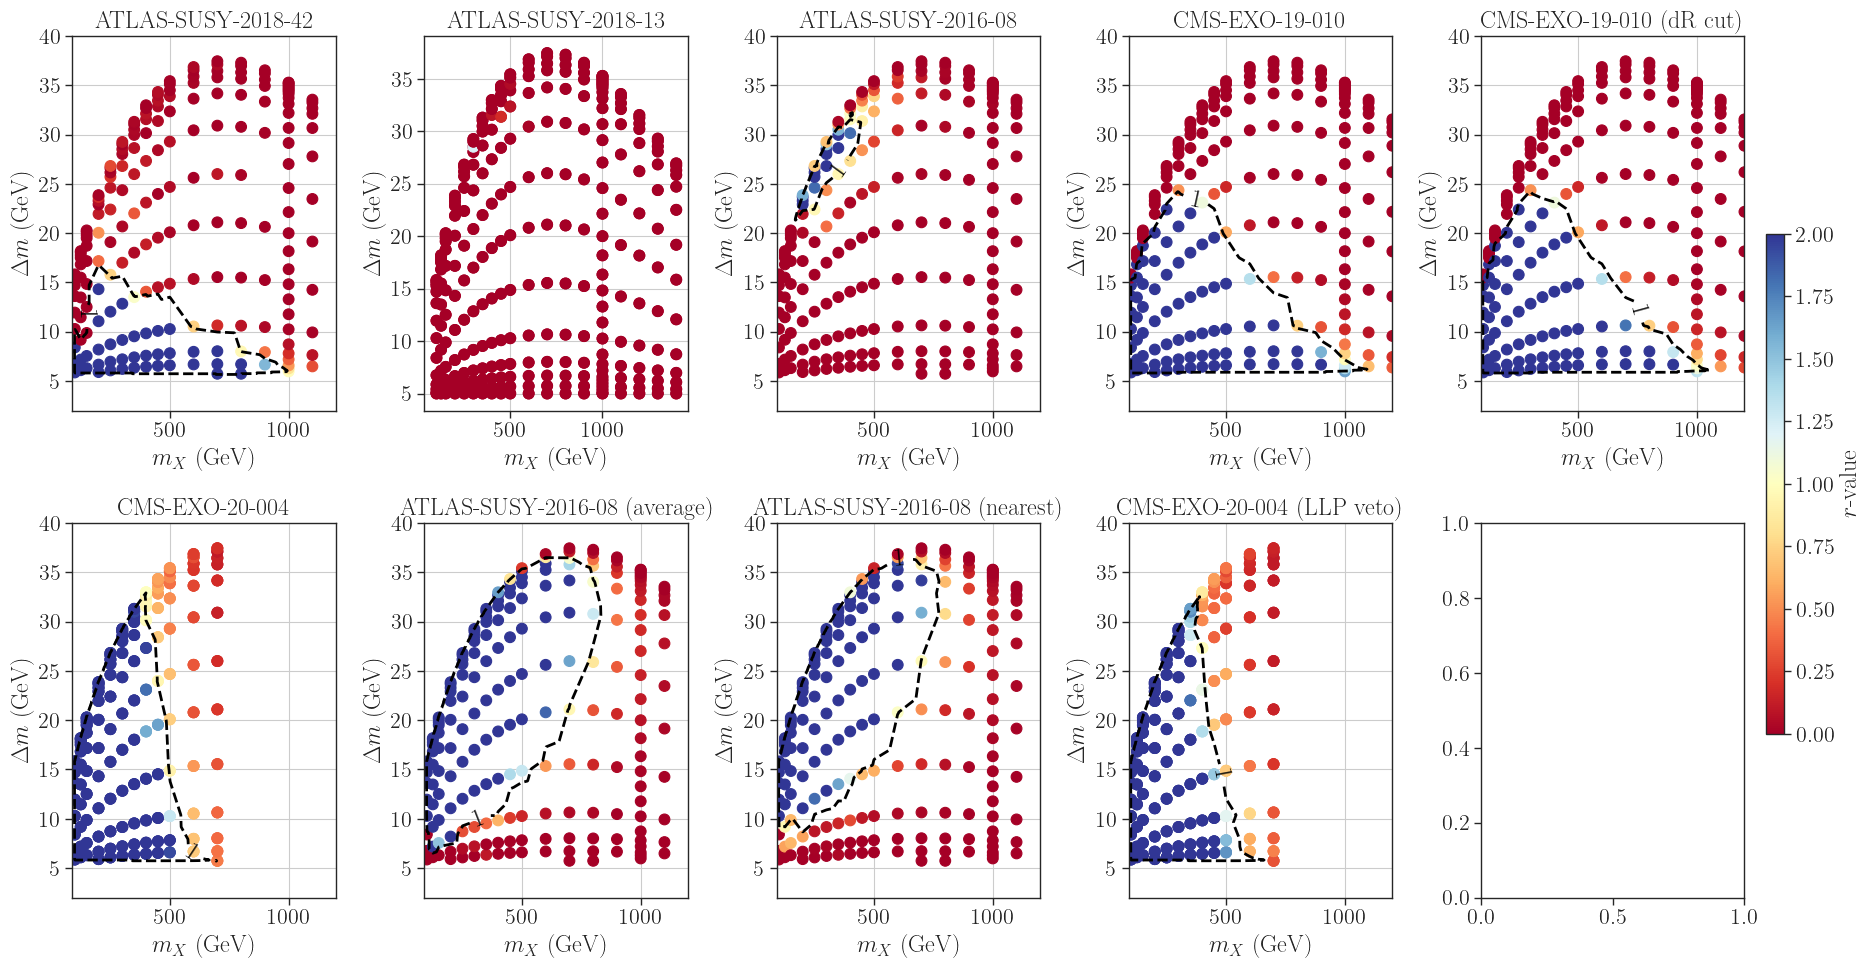

In [52]:
fig,axarr = plt.subplots(nrows=2,ncols=int(len(recastDataDict)/2)+1,figsize=(18,10))
axarr = np.array(axarr).reshape(-1)

allContours = {}
for iplot,label in enumerate(recastDataDict):
    ax = axarr[iplot]
    recastData = recastDataDict[label]
    y = recastData[msb]-recastData[mn1]
    x = recastData[mn1]
    rValues = recastData['robs']*recastData['kfactor']
    p = ax.scatter(x=x,y=y,vmin=0.0,vmax=2.0,
            c=rValues,cmap=cm,s=60)
    
    # Interpolate to create more points
    xnew,ynew,znew = interpolateData(x,y,rValues,nx=nx,ny=ny,fill_value=0.0,xnew=xnew0,ynew=ynew0)
    cValues = sorted([1.])
    # Get contours
    # print(label,znew.max(),rValues.max())
    if znew.max() >= min(cValues):        
        contours = ax.contour(xnew, ynew, znew, cValues, colors='black',linestyles=['dashed','solid'],linewidths=2.0)
        ax.clabel(contours, inline=True, fontsize=18)
    
        allContours[label] = contours
    
    ax.set_xlabel(r'$m_{X}$ (GeV)')
    ax.set_ylabel(r'$\Delta m$ (GeV)')
    ax.set_title('%s' %label)
    # ax.set_xlim(50.0,1.1*x.max())
    # ax.set_ylim(5.0,1.1*y.max())
    ax.grid()

fig.subplots_adjust(right=0.9,top=1.1)
cbar_ax = fig.add_axes([0.99, 0.25, 0.01, 0.5]) 
fig.colorbar(p,label=r'$r$-value',cax=cbar_ax)
plt.tight_layout()
plt.show()

### Get all contours

In [53]:
allContours = {}
for label in recastDataDict:
    recastData = recastDataDict[label]
    y = recastData[msb]-recastData[mn1]
    x = recastData[mn1]
    rValues = recastData['robs']*recastData['kfactor']       
    # Interpolate to create more points
    xnew,ynew,znew = interpolateData(x,y,rValues,nx=nx,ny=ny,fill_value=0.0,xnew=xnew0,ynew=ynew0)    
    if znew.max() >= min(cValues):
        allContours[label] = getContours(xnew,ynew,znew,cValues)

In [54]:
colors = {}
labelCMS = [label for label in allContours if 'CMS' in label]
labelATLAS = [label for label in allContours if 'ATLAS' in label]

colors = {label : sns.color_palette("Paired")[i] for i,label in enumerate(sorted(allContours.keys(),reverse=True))}
newLabels = {
             'CMS-EXO-20-004' : r'CMS jets plus $E_{T}^{\rm miss}$',
             'CMS-EXO-20-004 (LLP veto)' : r'CMS jets plus $E_{T}^{\rm miss}$ (LLP veto)',
             'ATLAS-SUSY-2016-08' : r'ATLAS DV  plus $E_{T}^{\rm miss}$',
             'ATLAS-SUSY-2018-42' : 'ATLAS HSCP',
            #  'CMS-EXO-19-010' : 'CMS Disap. Track',
             'CMS-EXO-19-010 (dR cut)' : r'CMS DT ($\Delta R$ cut)',
             'ATLAS-SUSY-2016-08 (average)' : r'ATLAS DV  plus $E_{T}^{\rm miss}$ (average)',
             'ATLAS-SUSY-2016-08 (nearest)' : r'ATLAS DV  plus $E_{T}^{\rm miss}$ (nearest)',
             }

cpalette = sns.color_palette("Paired")
colors = {'CMS-EXO-20-004' : cpalette[0],
             'CMS-EXO-20-004 (LLP veto)' : cpalette[1],
             'ATLAS-SUSY-2016-08' : cpalette[5],
             'ATLAS-SUSY-2016-08 (average)' : cpalette[6],
             'ATLAS-SUSY-2016-08 (nearest)' : cpalette[7],
             'ATLAS-SUSY-2018-42' : cpalette[9],
             'CMS-EXO-19-010' : cpalette[8],
             'CMS-EXO-19-010 (dR cut)' : cpalette[3]  
             }

# colors = {label : sns.color_palette("Blues")[i+2] for i,label in enumerate(labelCMS)}
# colors.update({label :sns.color_palette('Reds_r',2*len(labelATLAS))[2*i] for i,label in enumerate(labelATLAS)})

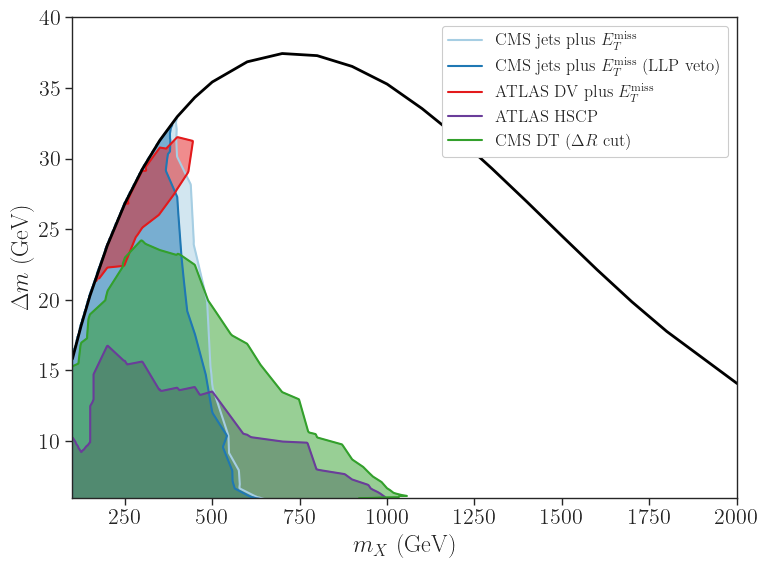

In [55]:
plt.figure(figsize=(8,6))
ptsAll = pd.concat(recastDataDict.values()).drop_duplicates(subset=[msb,mn1],keep='first')
x = ptsAll[mn1]
y = ptsAll[msb]-ptsAll[mn1]
# plt.scatter(x,y,c='lightgray',s=30)
for label,newL in newLabels.items():
    if ('nearest' in label.lower()) or ('average' in label.lower()):
        continue
    contours = allContours[label]
    if not contours:
        continue
    cVal = max(contours.keys())
    if cVal != 1.0:
        continue
    pts = contours[cVal][:-30] # Hack for avoiding out of order points
    plt.plot(pts[:,0],pts[:,1],label=newL,linewidth=1.5,c=colors[label])
    plt.fill(pts[:,0],pts[:,1],label=None,c=colors[label],alpha=0.5)

plt.plot(maxCurve[:,0],maxCurve[:,1],c='black',linewidth=2)
plt.xlim(100,2000)
plt.ylim(6,40)
plt.legend(loc='upper right',fontsize=12,framealpha=1.0)
plt.xlabel(r'$m_{X}$ (GeV)')
plt.ylabel(r'$\Delta m$ (GeV)')
plt.tight_layout()
plt.savefig('excCurves_mDV10.png')
plt.show()

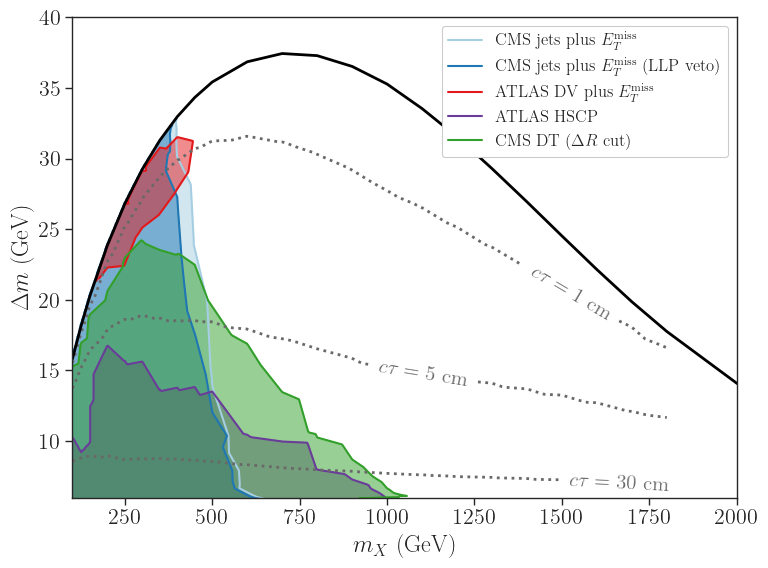

In [77]:
plt.figure(figsize=(8,6))
ptsAll = pd.concat(recastDataDict.values()).drop_duplicates(subset=[msb,mn1],keep='first')
# plt.scatter(x,y,c='lightgray',s=30)
for label,newL in newLabels.items():
    if ('nearest' in label.lower()) or ('average' in label.lower()):
        continue
    contours = allContours[label]
    if not contours:
        continue
    cVal = max(contours.keys())
    if cVal != 1.0:
        continue
    pts = contours[cVal][:-30] # Hack for avoiding out of order points
    plt.plot(pts[:,0],pts[:,1],label=newL,linewidth=1.5,c=colors[label])
    plt.fill(pts[:,0],pts[:,1],label=None,c=colors[label],alpha=0.5)

x = pts_scan['mxGeV']
y = pts_scan['deltamGeV']
z = pts_scan['ctaum']*100
y = y[x < 2000.]
z = z[x < 2000.]
x = x[x < 2000.]
xnew,ynew,znew = interpolateData(x,y,z,nx=250,ny=250)
contours = plt.contour(xnew,ynew,znew,[1.,5.,30.],linestyles='dotted',colors='dimgray',linewidths=2.0)
plt.clabel(contours, inline=True, fontsize=15, fmt=r'$c \tau = %1.0f$ cm',inline_spacing=10)

plt.plot(maxCurve[:,0],maxCurve[:,1],c='black',linewidth=2)
plt.xlim(100,2000)
plt.ylim(6,40)
plt.legend(loc='upper right',fontsize=12,framealpha=1.0)
plt.xlabel(r'$m_{X}$ (GeV)')
plt.ylabel(r'$\Delta m$ (GeV)')
plt.tight_layout()
plt.savefig('excCurves_mDV10_v2.png')
plt.show()

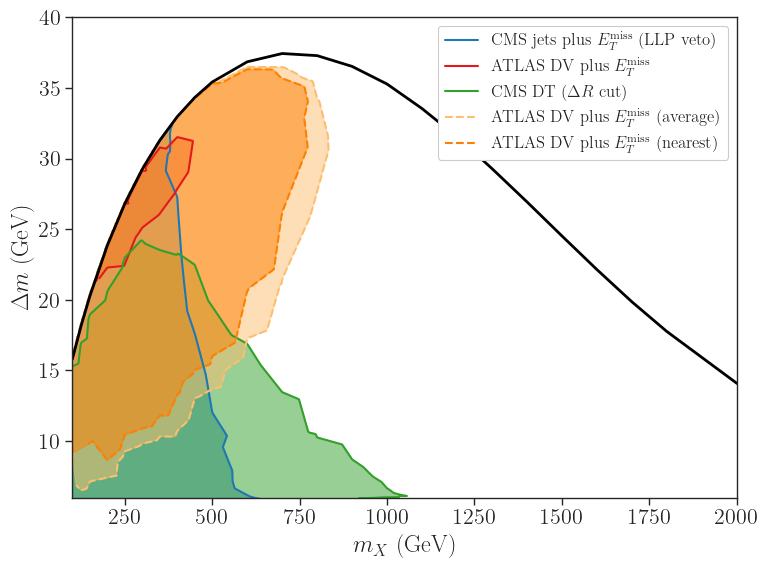

In [57]:
plt.figure(figsize=(8,6))
# plt.scatter(x,y,c='lightgray',s=30)
for label,newL in newLabels.items():
    contours = allContours[label]
    if label == 'CMS-EXO-20-004':
        continue
    if label == 'ATLAS-SUSY-2018-42':
        continue    
    if not contours:
        continue
    cVal = max(contours.keys())
    if cVal != 1.0:
        continue
    pts = contours[cVal][:-30] # Hack for avoiding out of order points
    if 'average' in label or 'nearest' in label:
        ls = 'dashed'
    else:
        ls = 'solid'
    plt.plot(pts[:,0],pts[:,1],label=newL,linewidth=1.5,c=colors[label],linestyle=ls)
    plt.fill(pts[:,0],pts[:,1],label=None,c=colors[label],alpha=0.5)

plt.plot(maxCurve[:,0],maxCurve[:,1],c='black',linewidth=2)
plt.xlim(100,2000)
plt.ylim(6,40)
plt.legend(loc='upper right',fontsize=12,framealpha=1.0)
plt.xlabel(r'$m_{X}$ (GeV)')
plt.ylabel(r'$\Delta m$ (GeV)')
plt.tight_layout()
plt.savefig('excCurves_mDV5.png')
# plt.grid()
plt.show()

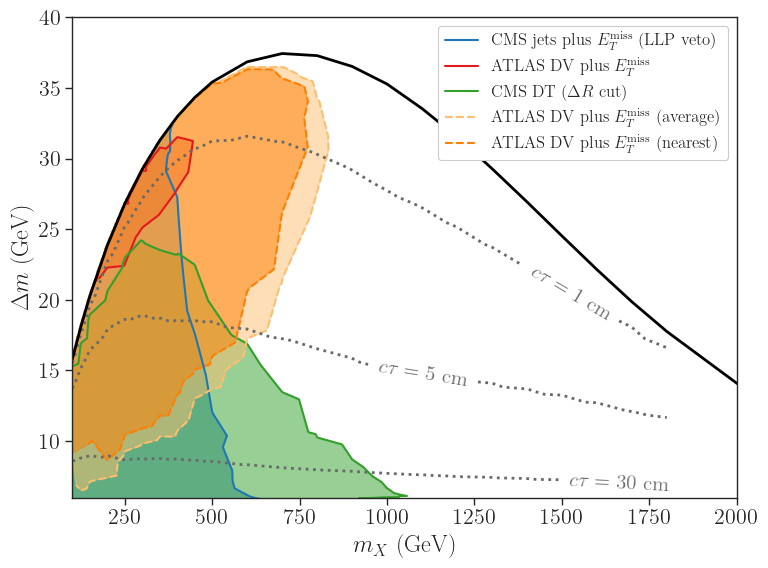

In [78]:
plt.figure(figsize=(8,6))
# plt.scatter(x,y,c='lightgray',s=30)
for label,newL in newLabels.items():
    contours = allContours[label]
    if label == 'CMS-EXO-20-004':
        continue
    if label == 'ATLAS-SUSY-2018-42':
        continue    
    if not contours:
        continue
    cVal = max(contours.keys())
    if cVal != 1.0:
        continue
    pts = contours[cVal][:-30] # Hack for avoiding out of order points
    if 'average' in label or 'nearest' in label:
        ls = 'dashed'
    else:
        ls = 'solid'
    plt.plot(pts[:,0],pts[:,1],label=newL,linewidth=1.5,c=colors[label],linestyle=ls)
    plt.fill(pts[:,0],pts[:,1],label=None,c=colors[label],alpha=0.5)

contours = plt.contour(xnew,ynew,znew,[1.,5.,30.],linestyles='dotted',colors='dimgray',linewidths=2.0)
plt.clabel(contours, inline=True, fontsize=15, fmt=r'$c \tau = %1.0f$ cm',inline_spacing=10)


plt.plot(maxCurve[:,0],maxCurve[:,1],c='black',linewidth=2)
plt.xlim(100,2000)
plt.ylim(6,40)
plt.legend(loc='upper right',fontsize=12,framealpha=1.0)
plt.xlabel(r'$m_{X}$ (GeV)')
plt.ylabel(r'$\Delta m$ (GeV)')
plt.tight_layout()
plt.savefig('excCurves_mDV5_v2.png')
# plt.grid()
plt.show()